# WarpAffine

In this notebook you'll learn how to use `warp_affine` operation.

## Introduction
### Warp Operators
All warp operators work by calculating the output pixels by sampling the source image at transformed coordinates:

$${Out}(x, y) = {In}(x_{src}, y_{src})$$

This way each output pixel is calculated exactly once.

If the source coordinates do not point exactly to pixel centers, the values of neighboring pixels will be interpolated or the nearst pixel is taken, depending on the interpolation method specified in the `interp_type` argument.

### Affine Transform

The source sample coordinates $x_{src}, y_{src}$ are calculated according to the formula:

$$
\begin{vmatrix}
x_{src} \\
y_{src}
\end{vmatrix}
= \begin{vmatrix}
m_{00} & m_{01} & t_x \\
m_{10} & m_{11} & t_y
\end{vmatrix}
\begin{vmatrix}
{x} \\
{y} \\
1
\end{vmatrix}
$$

Where $x, y$ are coordinates of the destination pixel and the matrix represents the inverse (destination to source) affine transform. The 
$\begin{vmatrix}
m_{00} & m_{01} \\
m_{10} & m_{11}
\end{vmatrix}$ block represents a combined rotate/scale/shear transform and $t_x, t_y$ is a translation vector.

## Usage Example

First, let's import the necessary modules and define the location of the dataset.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

test_data_root = os.environ["DALI_EXTRA_PATH"]
db_folder = os.path.join(test_data_root, "db", "lmdb")

The functions below define affine transofm matrices for a batch of images. Each image receives its own transform. The transform matrices are expected to be a tensor list of shape $batch\_size \times 2 \times 3$

In [2]:
def random_transform():
    dst_cx, dst_cy = (200, 200)
    src_cx, src_cy = (200, 200)

    # This function uses homogeneous coordinates - hence, 3x3 matrix

    # translate output coordinates to center defined by (dst_cx, dst_cy)
    t1 = np.array([[1, 0, -dst_cx], [0, 1, -dst_cy], [0, 0, 1]])

    def u():
        return np.random.uniform(-0.5, 0.5)

    # apply a randomized affine transform - uniform scaling + some random
    # distortion
    m = np.array([[1 + u(), u(), 0], [u(), 1 + u(), 0], [0, 0, 1]])

    # translate input coordinates to center (src_cx, src_cy)
    t2 = np.array([[1, 0, src_cx], [0, 1, src_cy], [0, 0, 1]])

    # combine the transforms
    m = np.matmul(t2, np.matmul(m, t1))

    # remove the last row; it's not used by affine transform
    return m[0:2, 0:3].astype(np.float32)


np.random.seed(seed=123)

Now, let's define the pipeline. It will apply the same transform to an image, with slightly different options.


The first variant executes on GPU and uses fixed output size and linear interpolation. It does not specify any fill value, in which case out-of-bounds destination coordinates are clamped to valid range.

The second executes on CPU and uses a `fill_value` argument which replaces the out-of-bounds source pixels with that value.

The last one executes on GPU and does not specify a new `size`, which keeps original image size.

In [3]:
@pipeline_def(seed=12)
def example_pipeline():
    # This example uses external_source to provide warp matrices
    transform = fn.external_source(
        batch=False, source=random_transform, dtype=types.FLOAT
    )

    # The reader reads raw files from some storage - in this case, a Caffe
    # LMDB container
    jpegs, labels = fn.readers.caffe(path=db_folder, random_shuffle=True)

    # The decoder takes tensors containing raw files and outputs images
    # as 3D tensors with HWC layout
    images = fn.decoders.image(jpegs)

    warped_gpu = fn.warp_affine(
        images.gpu(),
        transform.gpu(),  # pass the transform parameters through GPU memory
        size=(400, 400),  # specify the output size
        # fill_value,       # not specifying `fill_value`
        #  results in source coordinate clamping
        interp_type=types.INTERP_LINEAR,
    )  # use linear interpolation

    warped_cpu = fn.warp_affine(
        images,
        matrix=transform,  # pass the transform through a named input
        fill_value=200,
        size=(400, 400),  # specify the output size
        interp_type=types.INTERP_NN,
    )  # use nearest neighbor interpolation

    warped_keep_size = fn.warp_affine(
        images.gpu(),
        transform.gpu(),
        # size,        # keep the original canvas size
        interp_type=types.INTERP_LINEAR,
    )  # use linear interpolation
    return (
        labels,
        transform,
        images.gpu(),
        warped_gpu,
        warped_cpu.gpu(),
        warped_keep_size,
    )

The processing pipeline is now defined. In order to run it, we need to instantiate and build it.

In [4]:
batch_size = 32
pipe = example_pipeline(batch_size=batch_size, num_threads=2, device_id=0)
pipe.build()

Finally, we can call `run` on our pipeline to obtain the first batch of preprocessed images.

In [5]:
pipe_out = pipe.run()

## Example Output

Now that we've processed the first batch of images, let's see the results:

Affine transform matrix:
[[ 1.1964692  -0.21386066  3.4782958 ]
 [-0.27314854  1.0513147  44.366756  ]]


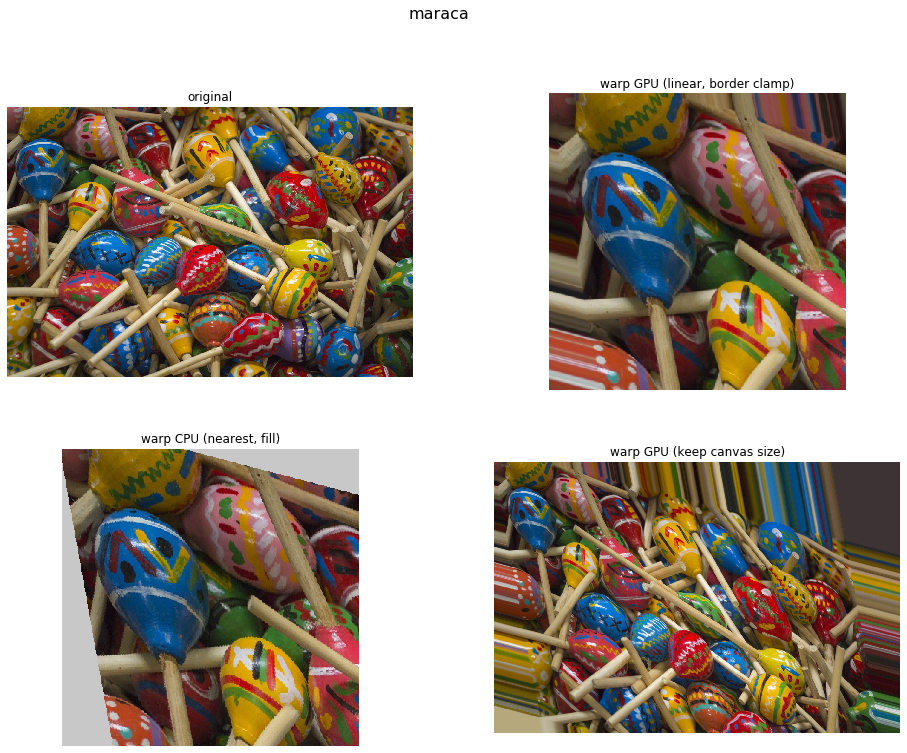

In [6]:
n = 0  # change this value to see other images from the batch;
# it must be in 0..batch_size-1 range

from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec

len_outputs = len(pipe_out) - 2

captions = [
    "original",
    "warp GPU (linear, border clamp)",
    "warp CPU (nearest, fill)",
    "warp GPU (keep canvas size)",
]

fig = plt.figure(figsize=(16, 12))
plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)

print("Affine transform matrix:")
print(pipe_out[1].at(n))

for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(captions[i])
    pipe_out_cpu = pipe_out[2 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw) / 255.0)